In [5]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [6]:
import sys
sys.path.append('/content/gdrive/MyDrive/ACSE-9')

# Making Predictions

In [7]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import pandas as pd
import time
!pip install vtk -q
import vtktools, tools_io
from tools_io import get_nNodes_from_vtu, get_clean_vtu_file

     |████████████████████████████████| 59.5 MB 35 kB/s 
     |████████████████████████████████| 3.1 MB 52.0 MB/s 
     |████████████████████████████████| 495 kB 63.6 MB/s 
     |████████████████████████████████| 3.0 MB 59.5 MB/s 
     |████████████████████████████████| 74 kB 4.7 MB/s 
     |████████████████████████████████| 251 kB 71.2 MB/s 
     |████████████████████████████████| 1.3 MB 70.0 MB/s 
     |████████████████████████████████| 142 kB 75.6 MB/s 
     |████████████████████████████████| 294 kB 68.6 MB/s 


In [8]:
'''
  # Uncomment if want to see google colab GPU information

%tensorflow_version 2.x
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

'''

'\n  # Uncomment if want to see google colab GPU information\n\n%tensorflow_version 2.x\ndevice_name = tf.test.gpu_device_name()\nif device_name != \'/device:GPU:0\':\n  raise SystemError(\'GPU device not found\')\nprint(\'Found GPU at: {}\'.format(device_name))\n\ngpu_info = !nvidia-smi\ngpu_info = \'\n\'.join(gpu_info)\nif gpu_info.find(\'failed\') >= 0:\n  print(\'Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, \')\n  print(\'and then re-execute this cell.\')\nelse:\n  print(gpu_info)\n\n'

### Data from compression using PCA (43 pod coefficients)

Load POD coefficients, PCA compression module, scalers and $CO_{2}$ sensor data

In [9]:
import joblib

enhanced_data_scaled = joblib.load('/content/gdrive/MyDrive/ACSE-9/models/enhanced_data_scaled_410.pkl')
scaler_pca = joblib.load('/content/gdrive/MyDrive/ACSE-9/models/scaler_pca_410.pkl')


enhanced_data = joblib.load('/content/gdrive/MyDrive/ACSE-9/models/enhanced_data_410.pkl')
pca = joblib.load('/content/gdrive/MyDrive/ACSE-9/output_pod_files/pca_compress_410.pkl')
scaler_minmax = joblib.load('/content/gdrive/MyDrive/ACSE-9/models/scaler_minmax_410.pkl')

scaler_std = joblib.load('/content/gdrive/MyDrive/ACSE-9/output_pod_files/scaler_std_410.pkl')
scaler_x = joblib.load('/content/gdrive/MyDrive/ACSE-9/output_pod_files/scaler_x_410.pkl')
scaler_y = joblib.load('/content/gdrive/MyDrive/ACSE-9/output_pod_files/scaler_y_410.pkl')
scaler_z = joblib.load('/content/gdrive/MyDrive/ACSE-9/output_pod_files/scaler_z_410.pkl')
scaler_enhanced = joblib.load('/content/gdrive/MyDrive/ACSE-9/models/CO2_scaler_minmax_410.pkl')

CO2data = joblib.load('/content/gdrive/MyDrive/ACSE-9/output_pod_files/CO2data_410.pkl') #CO2 snapshot matrix
CO2_sensor = joblib.load('/content/gdrive/MyDrive/ACSE-9/models/sensor_CO2_410.pkl')
CO2_sensor_all = joblib.load('/content/gdrive/MyDrive/ACSE-9/models/sensor_CO2_all.pkl')

### Prepare data for the GAN

In [10]:
X_train_scaled = enhanced_data_scaled.copy()
print(X_train_scaled.shape)
codings_size = X_train_scaled.shape[1]

(410, 50)


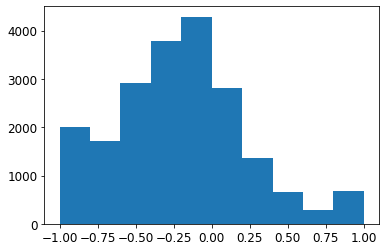

In [11]:
'''
  Histogram showing the frequency distribution; ensuring scaling between [-1,1]
'''
plt.hist(X_train_scaled.flatten())
X_test_scaled = X_train_scaled.copy()

### Creating a TensorFlow Dataset and splitting it into batches

In [12]:
def concat_timesteps(X_train, ntimes, step):
    '''
      The function takes in a 2D array, picks 9 time levels at a time and skips time levels if needed.  
      Parameters
      ----------

      X_train : 2D array
        Scaled enhanced array - (Time levels, No. reduced parameters)

      ntimes : int
        Number of consective outputs from the GAN

      step : int
        size of step to skip data
    '''
    X_train_concat = []
    for i in range(len(X_train) - ntimes*step):
        X_train_concat.append(X_train[i:i+ntimes*step:step])
    return np.array(X_train_concat) 

In [13]:
ntimes = 9  # consecutive times for the GAN
step = 1 # step between times

# X_train_concat = concat_timesteps(X_train_scaled, ntimes, step)
X_train_concat = concat_timesteps(X_test_scaled, ntimes, step)
print("X_train_concat: ", np.shape(X_train_concat))
X_train_concat_flatten = X_train_concat.reshape(X_train_concat.shape[0], codings_size*ntimes )
print("X_train_concat_flatten: ", X_train_concat_flatten.shape)


X_train_4d = X_train_concat.reshape((X_train_concat.shape[0], ntimes, X_train_concat.shape[2], 1))  #(148706, 100, 81, 1)
print("X_train_4d: ", X_train_4d.shape)

X_train_concat:  (401, 9, 50)
X_train_concat_flatten:  (401, 450)
X_train_4d:  (401, 9, 50, 1)


### Loading the saved trained GAN

In [14]:
# loading saved model
from tensorflow.keras.models import load_model
generator, discriminator = load_model('/content/gdrive/MyDrive/ACSE-9/models/GAN_model_410_15_08_v4.h5', compile=False).layers

In [15]:
'''
  Setting seeds and latence space hyper-parameter
'''

np.random.seed(42)
tf.random.set_seed(42)
latent_space = 50

In [16]:
'''
  Ensuring consistency with the DA-PredGAN for accurate comparison
  the weights have been set up in a similar way

  Using pca.singular_values / pca.singular_values determining the POD
  coefficient weights. With tuned importance parameter for both 
  sensor and pod functionals
'''
delta_obs = 120
delta_pod = 2

# POD coefficients

weight_pod = 0.005*pca.singular_values_/pca.singular_values_.sum()
weight_pod = tf.constant(weight_pod, dtype=tf.float32)

print('weight_pod: ', weight_pod, end='\n\n')

# sensor data
weight_sens = 0.5*((delta_pod/delta_obs)**2)*ntimes*np.ones(shape=(7,))
weight_sens =  tf.constant(weight_sens, dtype=tf.float32)
print('weight_sens', weight_sens, end='\n\n')

weight = np.concatenate([weight_pod, weight_sens], axis=0)

weight

weight_pod:  tf.Tensor(
[8.95549136e-04 6.87052787e-04 3.61452985e-04 3.05079913e-04
 2.11701394e-04 1.99069182e-04 1.75359120e-04 1.70242463e-04
 1.50240885e-04 1.32018919e-04 1.25000573e-04 1.17453004e-04
 1.03867380e-04 9.59952158e-05 9.05701963e-05 8.25092720e-05
 7.86452074e-05 7.01978570e-05 6.70535810e-05 6.16597754e-05
 5.90184281e-05 5.33225502e-05 5.15014690e-05 5.06396245e-05
 4.60649026e-05 4.26181687e-05 4.08375854e-05 3.96352261e-05
 3.77834986e-05 3.73248986e-05 3.46608031e-05 3.29974573e-05
 3.17866288e-05 3.13663841e-05 2.99375024e-05 2.88857736e-05
 2.75469665e-05 2.66789157e-05 2.51995207e-05 2.38089251e-05
 2.32732109e-05 2.26611355e-05 2.17315956e-05], shape=(43,), dtype=float32)

weight_sens tf.Tensor([0.00125 0.00125 0.00125 0.00125 0.00125 0.00125 0.00125], shape=(7,), dtype=float32)



array([8.95549136e-04, 6.87052787e-04, 3.61452985e-04, 3.05079913e-04,
       2.11701394e-04, 1.99069182e-04, 1.75359120e-04, 1.70242463e-04,
       1.50240885e-04, 1.32018919e-04, 1.25000573e-04, 1.17453004e-04,
       1.03867380e-04, 9.59952158e-05, 9.05701963e-05, 8.25092720e-05,
       7.86452074e-05, 7.01978570e-05, 6.70535810e-05, 6.16597754e-05,
       5.90184281e-05, 5.33225502e-05, 5.15014690e-05, 5.06396245e-05,
       4.60649026e-05, 4.26181687e-05, 4.08375854e-05, 3.96352261e-05,
       3.77834986e-05, 3.73248986e-05, 3.46608031e-05, 3.29974573e-05,
       3.17866288e-05, 3.13663841e-05, 2.99375024e-05, 2.88857736e-05,
       2.75469665e-05, 2.66789157e-05, 2.51995207e-05, 2.38089251e-05,
       2.32732109e-05, 2.26611355e-05, 2.17315956e-05, 1.24999997e-03,
       1.24999997e-03, 1.24999997e-03, 1.24999997e-03, 1.24999997e-03,
       1.24999997e-03, 1.24999997e-03], dtype=float32)

### Predicting whole simulation

In [18]:
mse = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Nadam(5e-3, 0.7, 0.999)

def mse_loss(inp, outp, loss_weight):
    '''
      The function takes in Tensor 2D arrays, determines the  
      Parameters
      ----------

      inp : TF object
        real coding : batch of the training dataset

      outp : TF object
        generated output given specific latent values

      loss_weight : TF object
        array of shape (50,) corresponding to applied loss weight

      returns
      ---------

      mse(inp, outp) : mean square error
    '''
    inp = tf.reshape(inp, [-1, codings_size])*tf.math.sqrt(loss_weight)
    print("inp: ", inp)
    outp = tf.reshape(outp, [-1, codings_size])*tf.math.sqrt(loss_weight)
    print("outp:", outp)
    return mse(inp, outp)

In [19]:
@tf.function
def opt_step(latent_values, real_coding, loss_weight):
    '''
      Finds the loss between the first n-1 generated values and n-1 real values with the nth value as the prediction.
      If training for 9 time levels, it finds the loss between the first 8 outputs from the generator and 8 real 
      Parameters
      ----------

      latent_values : array (1,50)
        latent values for generating the generator output

      real_coding : array (1, 400)
        batch of the training dataset

      loss_weight : array (50,)
        corresponds to the applied weighting for the loss 
      
      returns
      ---------

      loss : float32
        mean squared error difference
        
    '''
    with tf.GradientTape() as tape:
        tape.watch(latent_values)
        gen_output = generator(latent_values, training=False)  #results from generator
        #codings_size is size of each output, ntimes is number of time levels. 
        loss = mse_loss(real_coding, gen_output[:,:(ntimes - 1),:,:], loss_weight) 
    
    gradient = tape.gradient(loss, latent_values)   #gradient of the loss ws to the input
    optimizer.apply_gradients(zip([gradient], [latent_values]))   #applies gradients to the input
    
    return loss

In [20]:
def optimize_coding(latent_values, real_coding, loss_weight, epochs=1000):
    '''
      The function returns the optimised input latent values that generate the desired output
      Parameters
      ----------
      
      latent_values : array (1,50)
        latent values for generating the generator output

      real_coding : array (1, 400)
        batch of the training dataset

      loss_weight : TF object
        array of shape (50,) corresponding to applied loss weight

      epochs : int (optional)
        defines the number of iterations the optimisation step occurs

      returns
      ---------

      mse(inp, outp) : mean square error

    '''
  
    for epoch in range(epochs):
        opt_step(latent_values, real_coding, loss_weight)
        
    return latent_values  
    

In [21]:
n = 0
# taking the first batch and casting it to a tf.float32 for applicable use
real_coding = X_train_concat[n].reshape(1,-1)
real_coding = real_coding[:,:codings_size*(ntimes - 1)]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

tic = time.time()

# making input latent values a tensorflow variable so it can be trained
latent_values = tf.random.normal([len(real_coding), latent_space])  
latent_values = tf.Variable(latent_values)     

# optimisation step determining the latent values that minimises the mse
# difference between the generated output and real coding 
latent_values = optimize_coding(latent_values, real_coding, weight, epochs=5000)
X_predict = list(generator(latent_values).numpy().reshape(-1,codings_size))
# taking the last (9th) as a prediction
gen_predict = X_predict[-1]
# appending it onto the end of real coding as now a known solution
real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,codings_size:]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

# iterating the above process outlined to predict the total number of required time-steps
# set to 446, which produces predictions up to 455 (446 + 9); the complete CFD timesteps)
for i in range(446):
    t1 = time.time()
    latent_values = optimize_coding(latent_values, real_coding, weight, epochs=100) #epochs=100
    gen_predict = generator(latent_values)[:,(ntimes - 1):,:,:].numpy()
    X_predict.append(gen_predict.flatten())
    real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,codings_size:]
    real_coding = tf.constant(real_coding)
    real_coding = tf.cast(real_coding, dtype=tf.float32)
    print(i)
    tmc = time.time()
    print ('\n\nTime : ', tmc - t1, 'sec')

X_predict = np.array(X_predict)
#X_predict_TEST = np.array(X_predict)
toc = time.time()
print ('\n\nTime : ', toc - tic, 'sec')

inp:  Tensor("mul:0", shape=(8, 50), dtype=float32)
outp: Tensor("mul_1:0", shape=(8, 50), dtype=float32)
inp:  Tensor("mul:0", shape=(8, 50), dtype=float32)
outp: Tensor("mul_1:0", shape=(8, 50), dtype=float32)
0


Time :  0.168809175491333 sec
1


Time :  0.16161656379699707 sec
2


Time :  0.16236019134521484 sec
3


Time :  0.1666734218597412 sec
4


Time :  0.1795649528503418 sec
5


Time :  0.1654958724975586 sec
6


Time :  0.17298674583435059 sec
7


Time :  0.16866588592529297 sec
8


Time :  0.16620445251464844 sec
9


Time :  0.16521525382995605 sec
10


Time :  0.1677100658416748 sec
11


Time :  0.16390275955200195 sec
12


Time :  0.17182421684265137 sec
13


Time :  0.16617393493652344 sec
14


Time :  0.1669635772705078 sec
15


Time :  0.16443943977355957 sec
16


Time :  0.16810059547424316 sec
17


Time :  0.1634378433227539 sec
18


Time :  0.17338275909423828 sec
19


Time :  0.17131972312927246 sec
20


Time :  0.18028020858764648 sec
21


Time :  0.16657805442810

In [22]:
'''
  This cell does inverse transforms and inverse scalings 
  appropriately to return to primitive variables for 
  analysis and evaluation of predictions

'''
# splitting of pod coefficients from sensor values
split_inv = np.split(X_predict, [43, ], axis=1)
alpha = split_inv[0]
print(alpha.shape)
# sensor loc values
sensor_CO2 = split_inv[-1]

print("GAN shape output of sensor CO2: ", sensor_CO2.shape)

#undoing alpha scaling
alpha_unscaled = scaler_pca.inverse_transform(alpha)
# undo pca transformation
X_recovered = pca.inverse_transform(alpha_unscaled)
print("X_recovered shape: ", X_recovered.shape)
# splitting pod coefficients to re-represent the co2, and velocity directions
X_unscaled = np.split(X_recovered, [int(X_recovered.shape[-1]/4), int(X_recovered.shape[-1]/2), int(X_recovered.shape[-1]*(3/4)), ], axis=1)

norm_co2_ = scaler_std.inverse_transform(X_unscaled[0])
norm_x_ = scaler_x.inverse_transform(X_unscaled[1])
norm_y_ = scaler_y.inverse_transform(X_unscaled[2])
norm_z_ = scaler_z.inverse_transform(X_unscaled[-1])
norm_sensor_CO2_ = scaler_enhanced.inverse_transform(sensor_CO2)

print("norm_co2_ shape: ", norm_co2_.shape)
print("norm_z_ shape: ", norm_z_.shape)
print("norm_sensor_CO2_ shape: ", norm_sensor_CO2_.shape)

(455, 43)
GAN shape output of sensor CO2:  (455, 7)
X_recovered shape:  (455, 595624)
norm_co2_ shape:  (455, 148906)
norm_z_ shape:  (455, 148906)
norm_sensor_CO2_ shape:  (455, 7)


In [ ]:
joblib.dump(norm_co2_, '/content/gdrive/MyDrive/ACSE-9/output_DA_files/norm_co2_Pred_22_08_v1.pkl')
joblib.dump(norm_x_, '/content/gdrive/MyDrive/ACSE-9/output_DA_files/norm_x_Pred_22_08_v1.pkl')
joblib.dump(norm_y_, '/content/gdrive/MyDrive/ACSE-9/output_DA_files/norm_y_Pred_22_08_v1.pkl')
joblib.dump(norm_z_, '/content/gdrive/MyDrive/ACSE-9/output_DA_files/norm_z_Pred_22_08_v1.pkl')
joblib.dump(norm_sensor_CO2_, '/content/gdrive/MyDrive/ACSE-9/output_DA_files/norm_sensor_CO2_Pred_22_08_v1.pkl')

['/content/gdrive/MyDrive/ACSE-9/output_DA_files/norm_sensor_CO2_Pred_22_08_v1.pkl']

In [23]:
'''
  Loading and inverse scaling original training set for evaluative and analysis
  comparisons with predictions
'''
X_train_pca = joblib.load('/content/gdrive/MyDrive/ACSE-9/output_pod_files/pod_coefficients_410.pkl')

X_pca_inv = pca.inverse_transform(X_train_pca)
print(X_pca_inv.shape)
real = np.split(X_pca_inv, [int(X_pca_inv.shape[-1]/4), int(X_pca_inv.shape[-1]/2), int(X_pca_inv.shape[-1]*(3/4)), ], axis=1)
print(real[0].shape)

real_co2_ = scaler_std.inverse_transform(real[0])
real_x_ = scaler_x.inverse_transform(real[1])
real_y_ = scaler_y.inverse_transform(real[2])
real_z_ = scaler_z.inverse_transform(real[-1])


(410, 595624)
(410, 148906)


In [ ]:
# norm_co2_ = joblib.load('/content/gdrive/MyDrive/ACSE-9/output_DA_files/norm_co2_Pred_19_08_v2.pkl')
# norm_x_ = joblib.load('/content/gdrive/MyDrive/ACSE-9/output_DA_files/norm_x_Pred_19_08_v2.pkl')
# norm_y_ = joblib.load('/content/gdrive/MyDrive/ACSE-9/output_DA_files/norm_y_Pred_19_08_v2.pkl')
# norm_z_ = joblib.load('/content/gdrive/MyDrive/ACSE-9/output_DA_files/norm_z_Pred_19_08_v2.pkl')
# norm_sensor_CO2_ = joblib.load('/content/gdrive/MyDrive/ACSE-9/output_DA_files/norm_sensor_CO2_Pred_19_08_v2.pkl')

### PredGAN plots for analysis and prediction comparisons
For more complete graphs, please see the results notebook

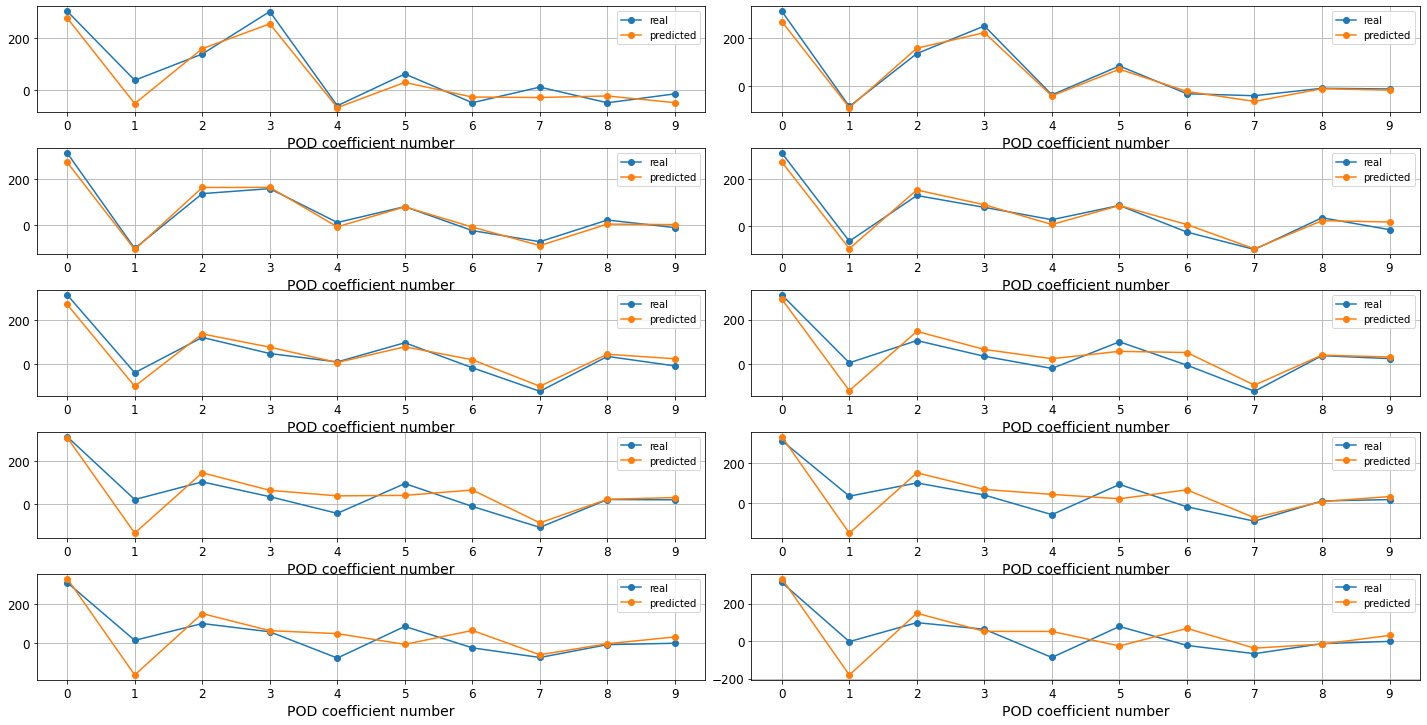

In [ ]:
fig, ax = plt.subplots(5,2, figsize=[20,10])
fig.tight_layout()
values = np.arange(1,10,1)
for i in range(0, 10, 1):
    ax.flatten()[i].plot(X_train_pca[i+9, :10], '-o', label='real')
    ax.flatten()[i].plot(alpha_unscaled[i+9, :10], '-o', label='predicted')
    ax.flatten()[i].legend()
    ax.flatten()[i].set_xlabel('POD coefficient number')
    ax.flatten()[i].set_xticks(np.arange(0,10,1))
    ax.flatten()[i].grid()

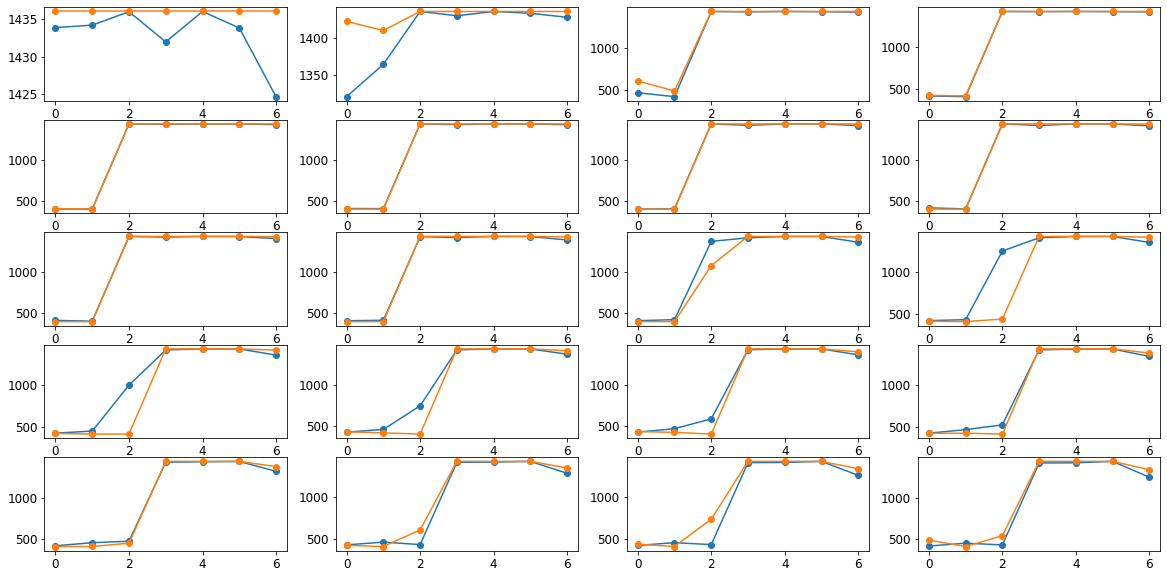

In [ ]:
fig, ax = plt.subplots(5,4, figsize=[20,10])
for i in range(20):
    ax.flatten()[i].plot(norm_sensor_CO2_[i,:], '-o')
    ax.flatten()[i].plot(CO2_sensor_all[i,:], '-o')

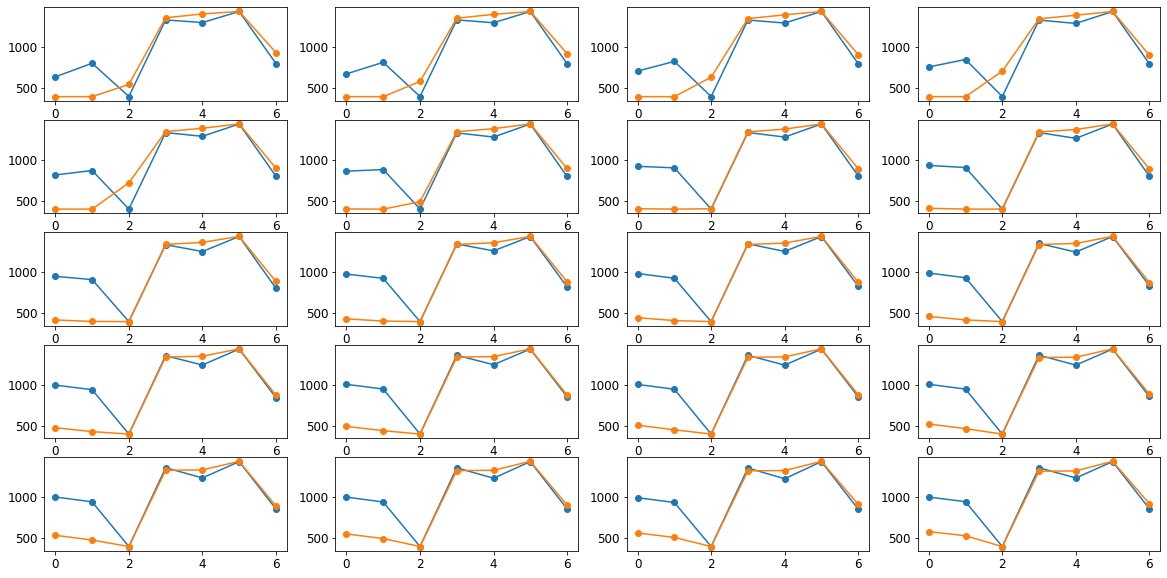

In [ ]:
fig, ax = plt.subplots(5,4, figsize=[20,10])
for i in range(20):
    ax.flatten()[i].plot(norm_sensor_CO2_[80+i,:], '-o')
    ax.flatten()[i].plot(CO2_sensor_all[80+i,:], '-o')

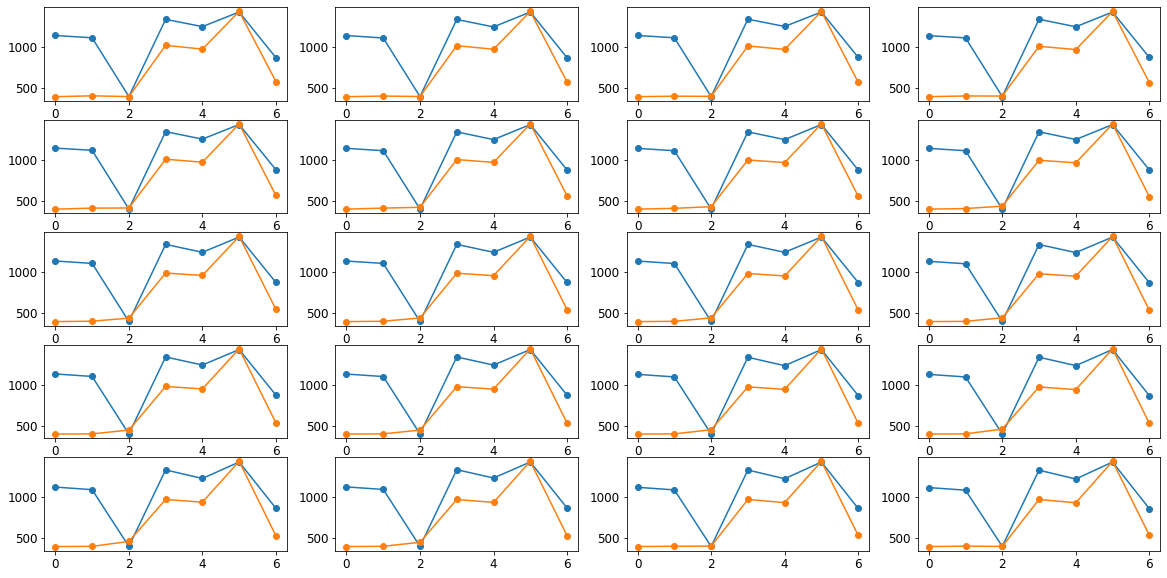

In [ ]:
fig, ax = plt.subplots(5,4, figsize=[20,10])
for i in range(20):
    ax.flatten()[i].plot(norm_sensor_CO2_[200+i,:], '-o')
    ax.flatten()[i].plot(CO2_sensor_all[200+i,:], '-o')

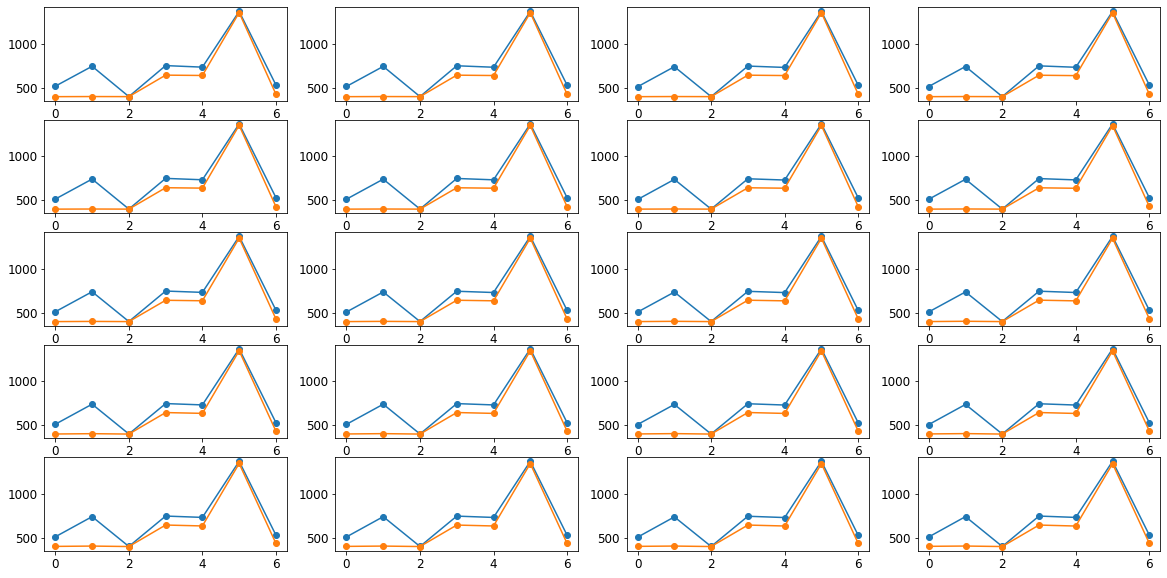

In [ ]:
fig, ax = plt.subplots(5,4, figsize=[20,10])
for i in range(20):
    ax.flatten()[i].plot(norm_sensor_CO2_[390+i,:], '-o')
    ax.flatten()[i].plot(CO2_sensor_all[390+i,:], '-o')

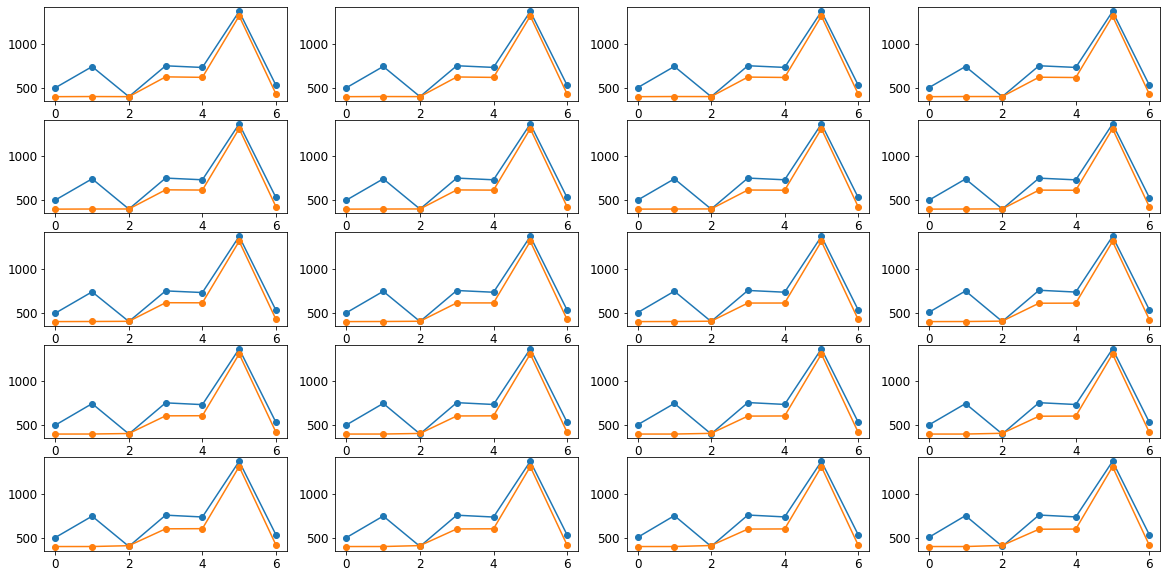

In [ ]:
fig, ax = plt.subplots(5,4, figsize=[20,10])
for i in range(20):
    ax.flatten()[i].plot(norm_sensor_CO2_[435+i,:], '-o')
    ax.flatten()[i].plot(CO2_sensor_all[435+i,:], '-o')

Loading in and comparing against current DA-PredGAN

In [ ]:
norm_sensor_CO2_DA = joblib.load('/content/gdrive/MyDrive/ACSE-9/output_DA_files/norm_sensor_CO2_DA_19_08_v2.pkl')

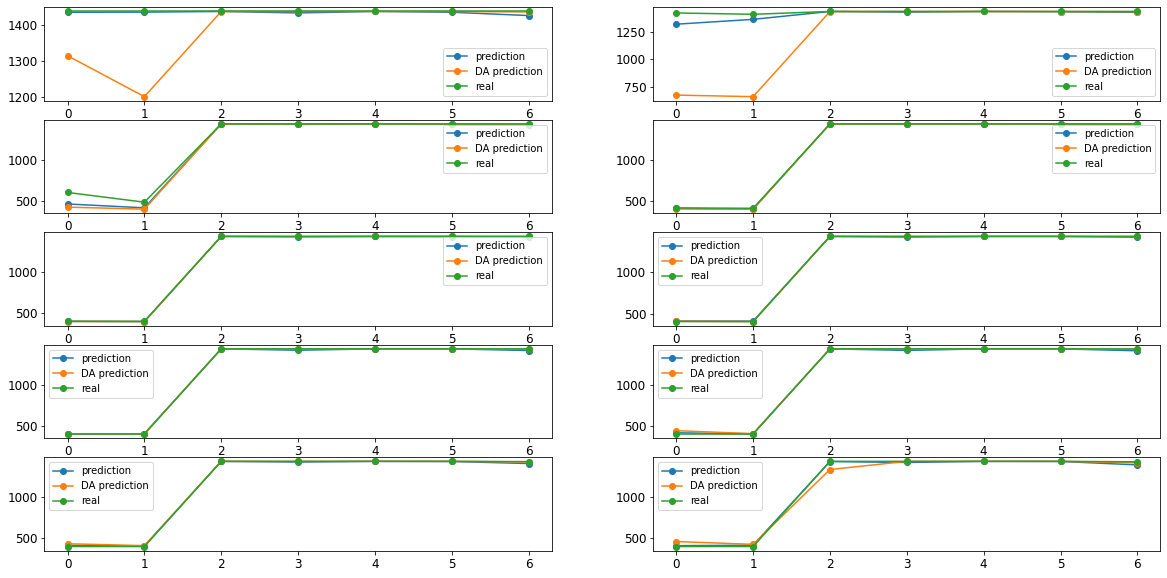

In [ ]:
fig, ax = plt.subplots(5,2, figsize=[20,10])
for i in range(10):
    ax.flatten()[i].plot(norm_sensor_CO2_[i,:], '-o')
    ax.flatten()[i].plot(norm_sensor_CO2_DA[i,:], '-o')
    ax.flatten()[i].plot(CO2_sensor_all[i,:], '-o')
    ax.flatten()[i].legend(['prediction', 'DA prediction', 'real'])

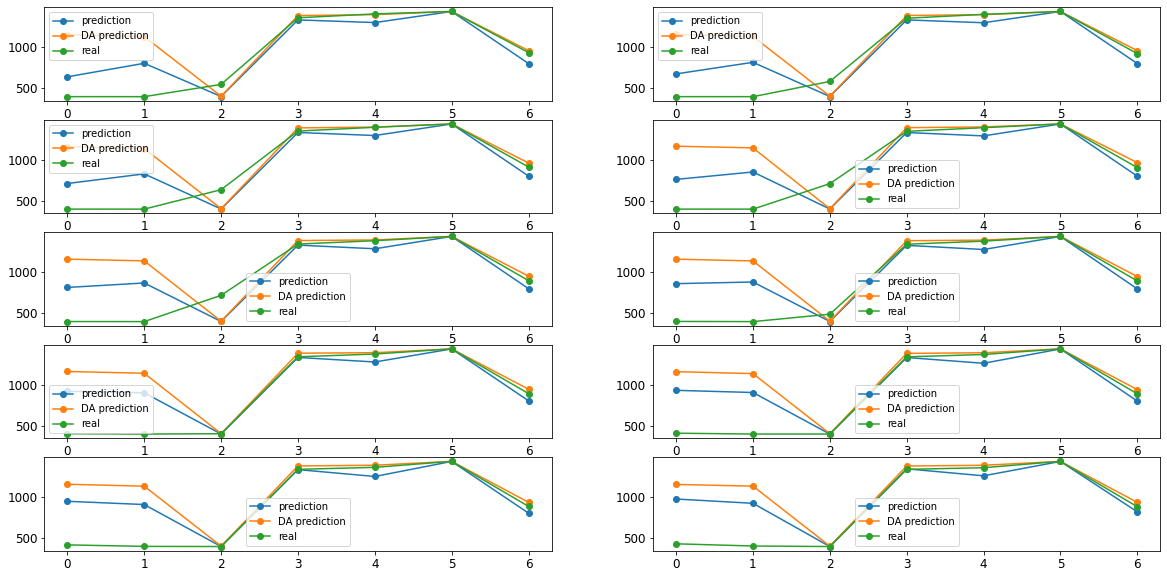

In [ ]:
fig, ax = plt.subplots(5,2, figsize=[20,10])
for i in range(10):
    ax.flatten()[i].plot(norm_sensor_CO2_[80+i,:], '-o')
    ax.flatten()[i].plot(norm_sensor_CO2_DA[80+i,:], '-o')
    ax.flatten()[i].plot(CO2_sensor_all[80+i,:], '-o')
    ax.flatten()[i].legend(['prediction', 'DA prediction', 'real'])

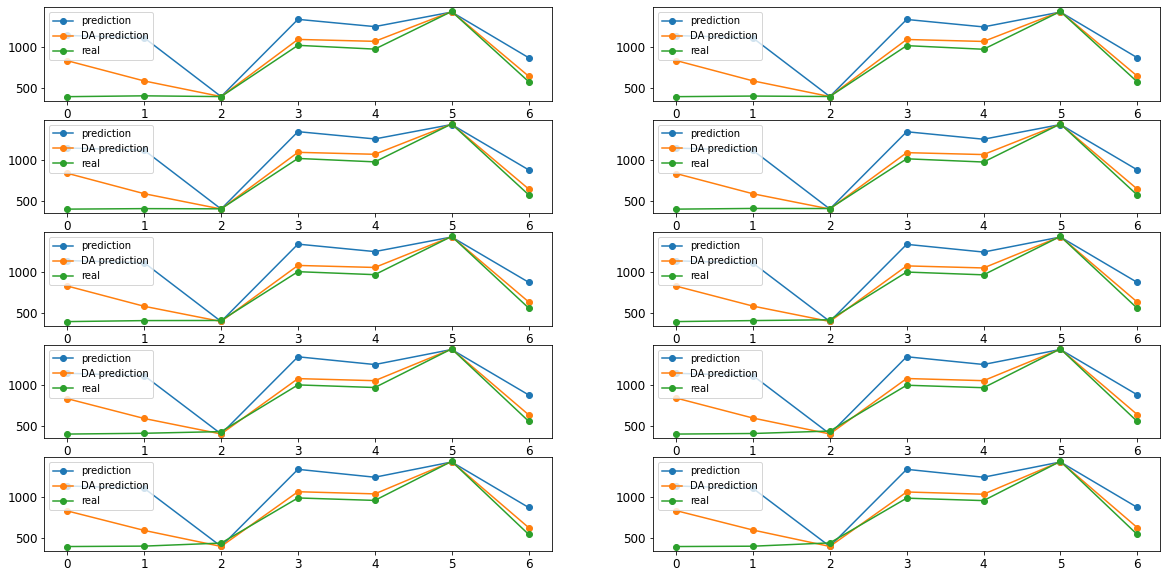

In [ ]:
fig, ax = plt.subplots(5,2, figsize=[20,10])
for i in range(10):
    ax.flatten()[i].plot(norm_sensor_CO2_[200+i,:], '-o')
    ax.flatten()[i].plot(norm_sensor_CO2_DA[200+i,:], '-o')
    ax.flatten()[i].plot(CO2_sensor_all[200+i,:], '-o')
    ax.flatten()[i].legend(['prediction', 'DA prediction', 'real'])

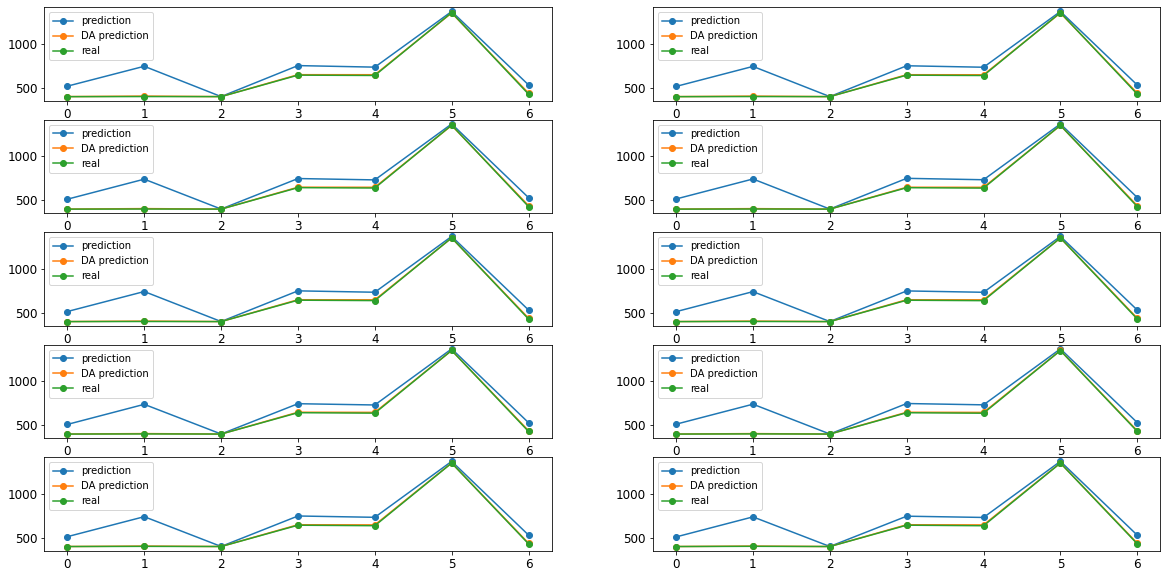

In [ ]:
fig, ax = plt.subplots(5,2, figsize=[20,10])
for i in range(10):
    ax.flatten()[i].plot(norm_sensor_CO2_[390+i,:], '-o')
    ax.flatten()[i].plot(norm_sensor_CO2_DA[390+i,:], '-o')
    ax.flatten()[i].plot(CO2_sensor_all[390+i,:], '-o')
    ax.flatten()[i].legend(['prediction', 'DA prediction', 'real'])

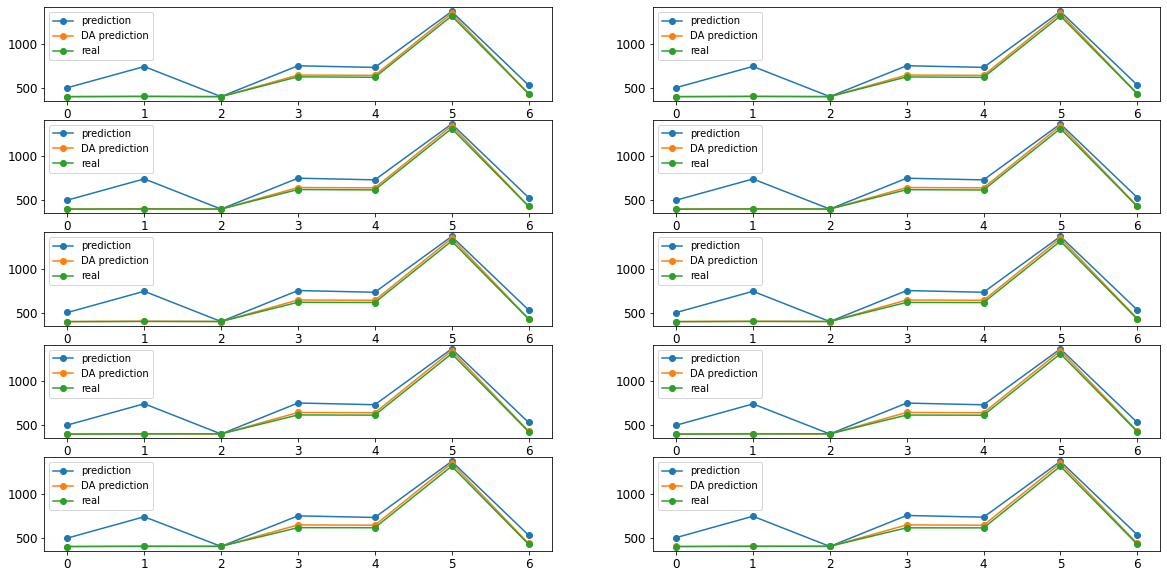

In [ ]:
fig, ax = plt.subplots(5,2, figsize=[20,10])
for i in range(10):
    ax.flatten()[i].plot(norm_sensor_CO2_[435+i,:], '-o')
    ax.flatten()[i].plot(norm_sensor_CO2_DA[435+i,:], '-o')
    ax.flatten()[i].plot(CO2_sensor_all[435+i,:], '-o')
    ax.flatten()[i].legend(['prediction', 'DA prediction', 'real'])

In [ ]:
def write_example_to_vtu(exm_num):
  # get clean vtu file
  snapshot_data_location = '/content/gdrive/MyDrive/ACSE-9/ClarenceCentre/run_Clip_ToSend/'
  snapshot_file_base = 'ClarenceCentre_'
  filename = snapshot_data_location + snapshot_file_base + '0.vtu'
  clean_vtu = get_clean_vtu_file(filename)

  # write results to vtu
  nNodes = get_nNodes_from_vtu(snapshot_data_location, snapshot_file_base)
  CO2_ppm = np.zeros((nNodes,1))
  velocity = np.zeros((nNodes,3))
  # sensor_CO2_ppm = np.zeros((7,1)) ## Dont need to add this to VTU

  new_vtu = vtktools.vtu()
  new_vtu.ugrid.DeepCopy(clean_vtu.ugrid)
  new_vtu.filename = '/content/gdrive/MyDrive/ACSE-9/predictions_410/prediction_' + str(exm_num) + '.vtu'

  CO2_ppm[:] = norm_co2_[exm_num].reshape((148906, 1),order='F')
  # for j in range(3):
  velocity[:,0] = norm_x_[exm_num].reshape((148906),order='F')
  velocity[:,1] = norm_y_[exm_num].reshape((148906),order='F') 
  velocity[:,2] = norm_z_[exm_num].reshape((148906),order='F')

  # sensor_CO2_ppm[:] = norm_sensor_CO2_[exm_num].reshape((7, 1), order='F') ## Dont need to add this to VTU


  new_vtu.AddField('CO2_ppm', CO2_ppm)
  new_vtu.AddField('Velocity', velocity)
  #new_vtu.AddField('Sensor_CO2_ppm', sensor_CO2_ppm) ## Dont need to add this field to VTU
  new_vtu.Write()

In [ ]:
# writing to vtu file
tic = time.time()
nVTU = norm_co2_.shape[0] 
for i in range(nVTU):
  tic = time.time()
  write_example_to_vtu(i)
  toc = time.time()
  print("PredGAN VTU file", i, "written in ", toc - tic, "seconds")
print("completed")

PredGAN VTU file 0 written in  9.689128637313843 seconds
PredGAN VTU file 1 written in  5.223367214202881 seconds
PredGAN VTU file 2 written in  5.513927459716797 seconds
PredGAN VTU file 3 written in  5.411571741104126 seconds
PredGAN VTU file 4 written in  5.460389137268066 seconds
PredGAN VTU file 5 written in  4.998457431793213 seconds
PredGAN VTU file 6 written in  5.73139762878418 seconds
PredGAN VTU file 7 written in  5.709973573684692 seconds
PredGAN VTU file 8 written in  5.328402042388916 seconds
PredGAN VTU file 9 written in  5.140681028366089 seconds
PredGAN VTU file 10 written in  5.381205320358276 seconds
PredGAN VTU file 11 written in  5.205137014389038 seconds
PredGAN VTU file 12 written in  5.232118606567383 seconds
PredGAN VTU file 13 written in  5.620279550552368 seconds
PredGAN VTU file 14 written in  5.378231048583984 seconds
PredGAN VTU file 15 written in  5.638711929321289 seconds
PredGAN VTU file 16 written in  5.374801158905029 seconds
PredGAN VTU file 17 writt

NEXT POINT PRED

In [ ]:
#trial
# from sklearn.preprocessing import MinMaxScaler
# scaler_weights = MinMaxScaler((1,3))
weights = np.ones(shape=(50,))
# pca_vals = scaler_weights.fit_transform(pca.singular_values_.reshape(-1, 1))
weight_pca = tf.constant(weights, dtype=tf.float32)
weight_pca

<tf.Tensor: shape=(50,), dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
      dtype=float32)>

In [ ]:
epochs = 50000
mse = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(2e-3, 0.9)

def mse_loss(inp, outp, loss_weight):
    inp = tf.reshape(inp, [-1, codings_size])*tf.math.sqrt(loss_weight)
    print("inp: ", inp)
    outp = tf.reshape(outp, [-1, codings_size])*tf.math.sqrt(loss_weight)
    print("outp:", outp)
    return mse(inp, outp)

In [ ]:
@tf.function
def opt_step(latent_values, real_coding, loss_weight):
    """ Finds the loss between the first n-1 generated values and n-1 real values with the nth value as the prediction"""
    with tf.GradientTape() as tape:
        tape.watch(latent_values)
        gen_output = generator(latent_values, training=False)  #results from generator
        loss = mse_loss(real_coding, gen_output[:,:(ntimes - 1),:,:], loss_weight)   #codings_size is size of each output, ntimes is number of time levels. 
        #If training for 9 time levels, it finds the loss between the first 8 outputs from the generator and 8 real outputs

    gradient = tape.gradient(loss, latent_values)   #gradient of the loss ws to the input
    optimizer.apply_gradients(zip([gradient], [latent_values]))   #applies gradients to the input
    
    return loss

In [ ]:
def optimize_coding(real_coding, loss_weight):
    latent_values = tf.random.normal([len(real_coding), latent_space])  
    latent_values = tf.Variable(latent_values)     #make input a tensorflow variable so it can be trained
    
    loss = []
    for epoch in range(epochs):
        loss.append(opt_step(latent_values, real_coding, loss_weight).numpy())
        
    plt.plot(loss)
    plt.xlabel("Epochs")
    plt.ylabel("Mean Square Loss")
    plt.grid()
    plt.show
        
    return latent_values  #returns the optimized input that generates the desired output

In [ ]:
n = 0 # start time level
print(X_train_concat.shape)
real_coding = X_train_concat_flatten[n].reshape(1,-1)
print(real_coding.shape)
real_coding = real_coding[:,:codings_size*(ntimes - 1)]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

(401, 9, 50)
(1, 450)


In [ ]:
#checks
latent_values = tf.random.normal([len(real_coding), latent_space])
print(latent_values.shape)
gen_output = generator(latent_values, training=False)[:,:(ntimes - 1),:,:]  #results from generator
print(gen_output.shape)
print(real_coding.shape)
print(weight_pca.shape)

(1, 150)
(1, 8, 50, 1)
(1, 400)
(50,)


inp:  Tensor("mul:0", shape=(8, 50), dtype=float32)
outp: Tensor("mul_1:0", shape=(8, 50), dtype=float32)
inp:  Tensor("mul:0", shape=(8, 50), dtype=float32)
outp: Tensor("mul_1:0", shape=(8, 50), dtype=float32)
inp:  tf.Tensor(
[[ 0.9991034  -0.29341245  0.71321946 -0.75452346 -0.80064803  0.8053223
   0.93409646  0.98700494  0.9696767  -0.973065   -0.9968172   0.19517794
  -0.6942059  -0.34537148 -0.30888313 -0.22931899  0.1251035  -0.25073582
   0.15948994 -0.22155368 -0.08435484 -0.11929417 -0.07786385 -0.00738567
  -0.16868629 -0.30685657 -0.15693977 -0.03718677 -0.14764303 -0.06847219
  -0.07159426  0.01237889 -0.01416392 -0.06822975 -0.06269581 -0.08649731
  -0.12376825  0.05664993  0.04286005 -0.32311252 -0.4667801  -0.21061943
  -0.32288092  0.9959225   0.9925677   0.98878616  0.92871714  0.9939519
   0.8820111   0.9778947 ]
 [ 0.9987872   0.8034677   0.9016406  -0.3958891   0.79745424  0.22262183
  -0.72419345 -0.19278172 -0.6052191   0.8857239   0.96499205 -0.82062775
   0.9

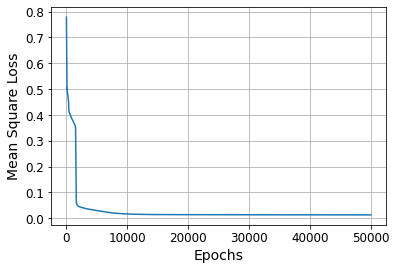

In [ ]:
latent_values = optimize_coding(real_coding, weight_pca)
print('Loss: ', mse_loss(generator(latent_values)[:,:(ntimes - 1),:,:], real_coding, weight_pca).numpy())
# print('Loss: ', mse_loss(generator(latent_values)[:, ntimes:,:,:], real_coding, weight_pca).numpy())
print(latent_values)

In [ ]:
gen_out = generator(latent_values, training=False)
print(gen_out.shape)
gen = gen_out[0].numpy().reshape(9, 50)

GAN_inverse = scaler_minmax.inverse_transform(gen)#.reshape(gen.shape[0]*4, int(gen.shape[1]/4))
print(GAN_inverse.shape)
split_inv = np.split(GAN_inverse, [43, ], axis=1)
alpha = split_inv[0]
print(alpha.shape)
sensor_CO2 = split_inv[-1]

print("GAN shape output of sensor CO2: ", sensor_CO2.shape)


 
X_recovered = pca.inverse_transform(alpha)
print(X_recovered.shape)
# X_unscaled = []
# for i in range(9):
#   X_unscaled.append(scaler_std.inverse_transform(X_recovered[4*i, ].reshape(1, -1)))
#   X_unscaled.append(scaler_x.inverse_transform(X_recovered[4*i + 1, ].reshape(1, -1)))
#   X_unscaled.append(scaler_y.inverse_transform(X_recovered[4*i + 2, ].reshape(1, -1)))
#   X_unscaled.append(scaler_z.inverse_transform(X_recovered[4*i + 3, ].reshape(1, -1)))

X_unscaled = np.split(X_recovered, [int(X_recovered.shape[-1]/4), int(X_recovered.shape[-1]/2), int(X_recovered.shape[-1]*(3/4)), ], axis=1)

norm_co2_ = scaler_std.inverse_transform(X_unscaled[0])
norm_x_ = scaler_x.inverse_transform(X_unscaled[1])
norm_y_ = scaler_y.inverse_transform(X_unscaled[2])
norm_z_ = scaler_z.inverse_transform(X_unscaled[-1])
norm_sensor_CO2_ = scaler_enhanced.inverse_transform(sensor_CO2)

print("norm_co2_ shape: ", norm_co2_.shape)
print("norm_z_ shape: ", norm_z_.shape)
print("norm_sensor_CO2_ shape: ", norm_sensor_CO2_.shape)

(1, 9, 50, 1)
(9, 50)
(9, 43)
GAN shape output of sensor CO2:  (9, 7)
(9, 595624)
norm_co2_ shape:  (9, 148906)
norm_z_ shape:  (9, 148906)
norm_sensor_CO2_ shape:  (9, 7)


In [ ]:
print(norm_co2_[0].shape)
print(norm_z_[0].shape)
print(norm_sensor_CO2_[0].shape)
print(norm_co2_.max())
print(norm_co2_.min())

(148906,)
(148906,)
(7,)
1986.2820596119209
184.47584168446798


### CO2 at sensor location 
Depiction of the difference between generated and real data points at sensor locations

In [ ]:
# for i in range(8):
#   print(norm_sensor_CO2_[i,:])

# print("\n")
# for i in range(8):
#   print(CO2_sensor[i,:])
#print(CO2_sensor.shape)
print(CO2_sensor[70:80,4])

[1430.86534293 1430.13243161 1429.24170161 1428.0514819  1426.53724923
 1424.49624266 1422.08162598 1419.0259418  1415.44103357 1411.23756432]


 Graph for each sensor location at time progresses

In [ ]:
# #Generated outputs
# fig, ax = plt.subplots(2,4, figsize=[20,10])
# for i in range(8):
#     if (i == 7):
#       fig.delaxes(ax[1,3])
#     else:
#       ax.flatten()[i].plot(norm_sensor_CO2_[:9,i], '-o')


In [ ]:
# # Clarence Centre CFD outputs
# fig, ax = plt.subplots(2,4, figsize=[20,10])
# #plt.ylim(300, 1700)
# for i in range(8):
#     if (i == 7):
#       fig.delaxes(ax[1,3])
#     else:
#       ax.flatten()[i].plot(CO2_sensor[:9,i-1], '-o', color='#F97306')

In [ ]:
# fig, ax = plt.subplots(2,4, figsize=[20,10])
# for i in range(8):
#     if (i == 7):
#       fig.delaxes(ax[1,3])
#     else:
#       ax.flatten()[i].plot(norm_sensor_CO2_[:9,i], '-o')
#       ax.flatten()[i].plot(CO2_sensor[:9,i], '-o', color='#F97306')

Graph for each Time level showing each 7 sensor location points

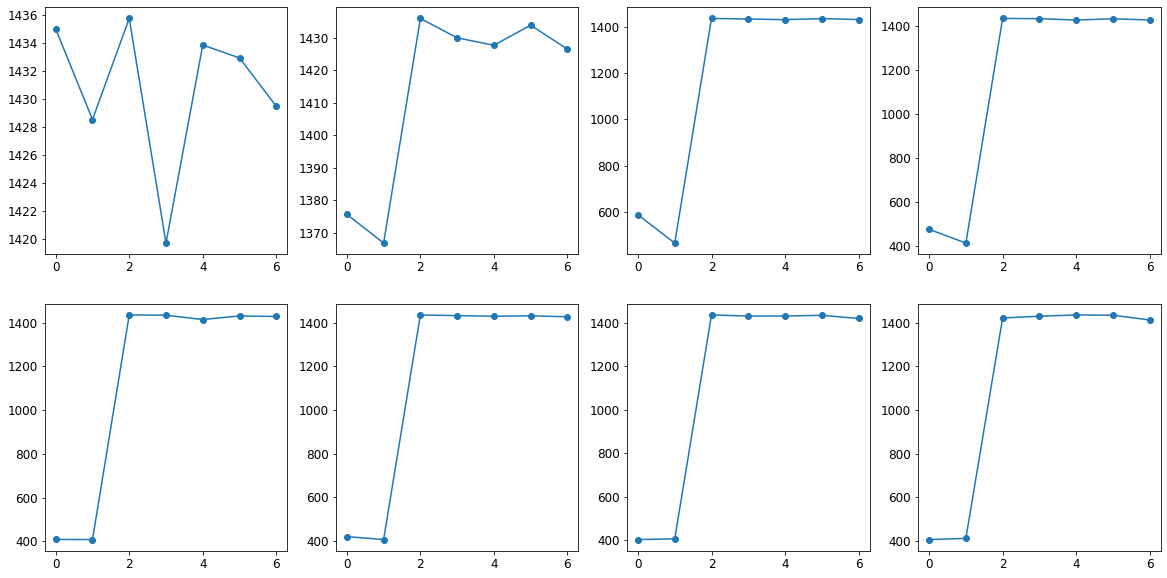

In [ ]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i in range(8):
    ax.flatten()[i].plot(norm_sensor_CO2_[i,:], '-o')

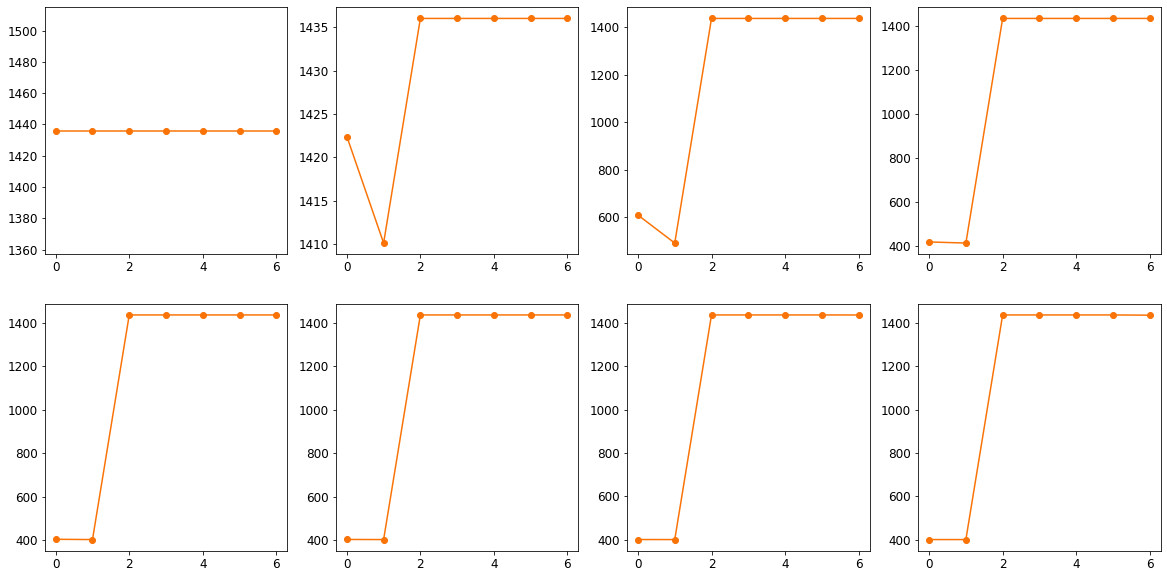

In [ ]:
# Clarence Centre CFD outputs

fig, ax = plt.subplots(2,4, figsize=[20,10])
for i in range(8):
    ax.flatten()[i].plot(CO2_sensor[i,:], '-o', color='#F97306')

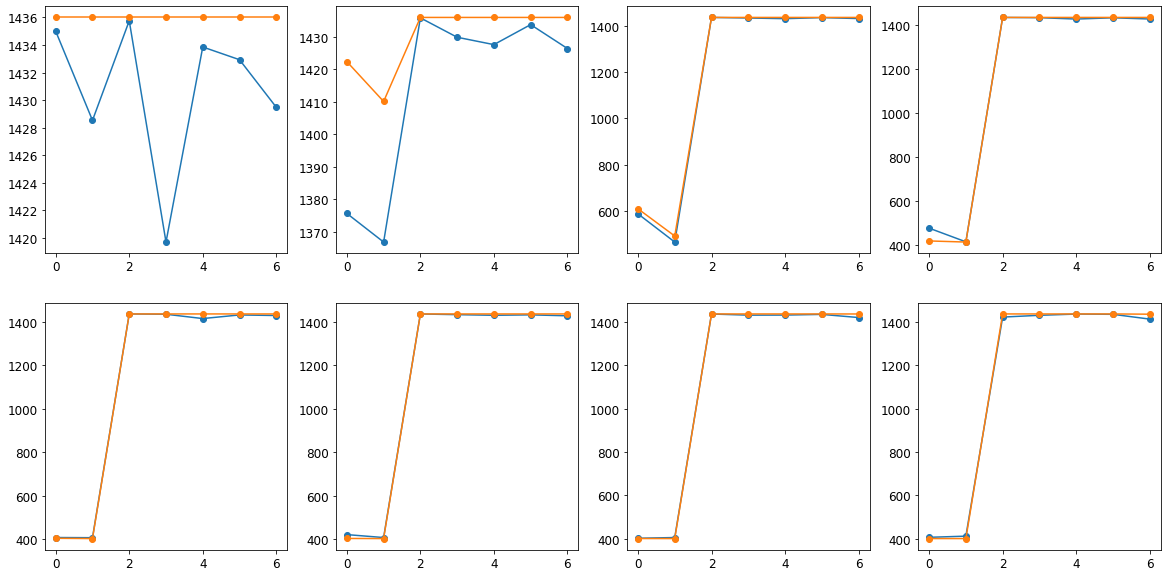

In [ ]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i in range(8):
    ax.flatten()[i].plot(norm_sensor_CO2_[i,:], '-o')
    ax.flatten()[i].plot(CO2_sensor[i,:], '-o')

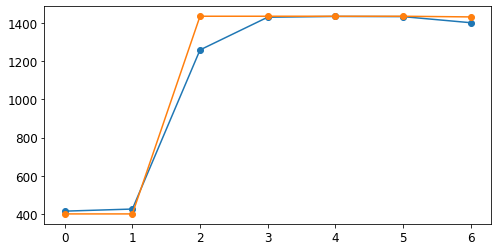

In [ ]:
# Next time level prediction for all sensor locations

fig, ax = plt.subplots(1,1, figsize=[8,4])
ax.plot(norm_sensor_CO2_[8,:], '-o')
ax.plot(CO2_sensor[8,:], '-o')

In [ ]:
print(norm_sensor_CO2_[:9, :], "\n")
print(CO2_sensor[:9, :])

[[1414.8221  1416.6205  1398.5692  1429.6697  1435.4497  1435.8026
  1403.6813 ]
 [1373.387   1380.302   1372.2347  1427.5525  1435.5884  1435.9193
  1401.1284 ]
 [ 591.12524  541.9944  1416.1685  1428.9178  1435.4326  1435.9482
  1414.6111 ]
 [ 421.19574  405.62076 1428.4865  1433.604   1435.7279  1435.968
  1420.3977 ]
 [ 413.35617  405.74237 1429.5658  1434.6737  1435.5435  1435.9668
  1415.1594 ]
 [ 432.30728  406.70102 1427.515   1434.9691  1434.8577  1435.9852
  1417.142  ]
 [ 421.00754  402.7965  1427.3905  1434.5417  1434.1737  1435.9866
  1414.5629 ]
 [ 452.92477  406.1854  1401.1625  1433.3787  1434.7898  1435.9014
  1402.2703 ]
 [ 495.34143  415.07367 1391.5015  1432.8558  1433.8354  1435.8044
  1398.5046 ]] 

[[1436.         1436.         1436.         1436.         1436.
  1436.         1436.        ]
 [1422.40820872 1410.14729655 1436.         1436.         1436.
  1436.         1436.        ]
 [ 608.69587777  491.06084034 1436.         1436.         1436.
  1436.        

In [ ]:
# #checks

# print(np.allclose(X_real[7,:], X_real[8,:]))
# print(norm_sensor_CO2_[0,:])
# print(norm_sensor_CO2_[1,:])
# print("\n")
# print(X_real[0,:])
# print(X_real[1,:])

### testing#

In [ ]:
### testing#
import pprint as pprint

nPOD = 10
nVTU = 3
pod_data = np.arange(10,40,1).reshape(nVTU, nPOD)
print("pod_data: ", pod_data)
print(pod_data.shape)

nCO2 = 5
CO2_test = np.arange(100,115,1).reshape(nVTU, nCO2)
print("CO2_test: ", CO2_test)
print(CO2_test.shape)

trial_ = np.concatenate((pod_data, CO2_test), axis=1)
print("concatenated: ", trial_)
print(trial_.shape)

all = np.split(trial_, [nPOD, ], axis=1)
#print(np.shape(all))
print(all[0])

pod_data:  [[10 11 12 13 14 15 16 17 18 19]
 [20 21 22 23 24 25 26 27 28 29]
 [30 31 32 33 34 35 36 37 38 39]]
(3, 10)
CO2_test:  [[100 101 102 103 104]
 [105 106 107 108 109]
 [110 111 112 113 114]]
(3, 5)
concatenated:  [[ 10  11  12  13  14  15  16  17  18  19 100 101 102 103 104]
 [ 20  21  22  23  24  25  26  27  28  29 105 106 107 108 109]
 [ 30  31  32  33  34  35  36  37  38  39 110 111 112 113 114]]
(3, 15)
[[10 11 12 13 14 15 16 17 18 19]
 [20 21 22 23 24 25 26 27 28 29]
 [30 31 32 33 34 35 36 37 38 39]]


In [ ]:
# X = np.array(X_unscaled).reshape(X_recovered.shape[0], X_recovered.shape[1])
# gen_1 = X[0:4]
# gen_2 = X[5:9]
# gen_3 = X[10:14]
# gen_4 = X[15:19]
# gen_5 = X[20:24]
# gen_6 = X[25:29]
# gen_7 = X[30:34]
# gen_8 = X[38:42]
# gen_9 = X[43:47]

In [ ]:
# gen_1[0, :].shape

Writing to VTU file

In [ ]:
def write_example_to_vtu(exm_num):
  # get clean vtu file
  snapshot_data_location = '/content/gdrive/MyDrive/ACSE-9/ClarenceCentre/run_Clip_ToSend/'
  snapshot_file_base = 'ClarenceCentre_'
  filename = snapshot_data_location + snapshot_file_base + '0.vtu'
  clean_vtu = get_clean_vtu_file(filename)

  # write results to vtu
  nNodes = get_nNodes_from_vtu(snapshot_data_location, snapshot_file_base)
  CO2_ppm = np.zeros((nNodes,1))
  velocity = np.zeros((nNodes,3))
  # sensor_CO2_ppm = np.zeros((7,1)) ## Dont need to add this to VTU

  new_vtu = vtktools.vtu()
  new_vtu.ugrid.DeepCopy(clean_vtu.ugrid)
  new_vtu.filename = '/content/gdrive/MyDrive/ACSE-9/predictions_410/prediction_' + str(exm_num) + '.vtu'

  CO2_ppm[:] = norm_co2_[exm_num].reshape((148906, 1),order='F')
  # for j in range(3):
  velocity[:,0] = norm_x_[exm_num].reshape((148906),order='F')
  velocity[:,1] = norm_y_[exm_num].reshape((148906),order='F') 
  velocity[:,2] = norm_z_[exm_num].reshape((148906),order='F')

  # sensor_CO2_ppm[:] = norm_sensor_CO2_[exm_num].reshape((7, 1), order='F') ## Dont need to add this to VTU


  new_vtu.AddField('CO2_ppm', CO2_ppm)
  new_vtu.AddField('Velocity', velocity)
  #new_vtu.AddField('Sensor_CO2_ppm', sensor_CO2_ppm) ## Dont need to add this field to VTU
  new_vtu.Write()

In [ ]:
nVTU = gen_out.shape[1]

In [ ]:
# writing to vtu file
nVTU = gen_out.shape[1] #9
for i in range(nVTU):
  write_example_to_vtu(i)
  print("PredGAN VTU file", i, "written")
print("complete")

NameError: ignored

In [ ]:
np.allclose(norm_co2_[0], norm_co2_[4])

False